# Modélisation de l'occupation du sol avec U-Net

Le but de ce script est de générer et d'entraîner le modèle d'occupation du sol. 

Il chargera les patchs à partir du script ``preprocess.ipynb``, les divisera en ensembles d'entraînement et de test, utilisés pour ajuster le modèle, évaluer le modèle, et visualiser la différence entre le résultat réel du test et sa prédiction, et sauvegarder le modèle (pour une utilisation ultérieure peut-être).


In [1]:
# Bibliothèques standard
import os
import json

# Bibliothèques de manipulation de données
import pandas as pd
import numpy as np

# Bibliothèques de visualisation
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from PIL import ImageColor
from tensorflow.keras.models import load_model

# Bibliothèques de machine learning
import tensorflow as tf
from tensorflow.keras.regularizers import l1
import keras
from keras.layers import Conv2D, Conv2DTranspose, Dropout, MaxPooling2D, Input, concatenate
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Bibliothèques pour le traitement d'images et de données géospatiales
import rasterio as rio
from rasterio.enums import Resampling
import rasterio.warp as warp
from skimage.exposure import rescale_intensity
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.exposure import adjust_gamma


# Paramètres pour la gestion du GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2025-05-13 23:32:48.031673: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-13 23:32:48.049309: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-13 23:32:48.056108: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-13 23:32:48.186960: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1747171971.443314 22137

In [2]:
# Vérification de la configuration
print("Version de TensorFlow :", tf.__version__)
print("Version de CUDA :", tf.sysconfig.get_build_info()['cuda_version'])
print("Version de CuDNN :", tf.sysconfig.get_build_info()['cudnn_version'])
print("Nombre de GPUs disponible : ", len(tf.config.experimental.list_physical_devices('GPU')))

Version de TensorFlow : 2.17.0
Version de CUDA : 12.0
Version de CuDNN : 9
Nombre de GPUs disponible :  1


Charger les données

In [3]:
lc_dir = '/home/vertex_wsl/MEMOIRE_w/TEST_AVI3_w/data/lc.json'             # Fichier json pour le style des rasters

#Load Land Cover Parameter
lc = json.load(open(lc_dir))
lc_df = pd.DataFrame(lc)
lc_df["values_normalize"] = lc_df.index + 1
lc_df["palette"] = "#" + lc_df["palette"]

# Mapping from old to new values
values = lc_df["values"].to_list()
values_norm = lc_df["values_normalize"].to_list()
palette = lc_df["palette"].to_list()
labels = lc_df["label"].to_list()
dict_values = {}
dict_label = {}
dict_palette = {}
dict_palette_hex = {}
for x in range(0, len(values)):
    dict_values[values[x]] = values_norm[x]
    dict_label[values_norm[x]] = labels[x]
    dict_palette[values_norm[x]] = ImageColor.getrgb(palette[x])
    dict_palette_hex[values_norm[x]] = palette[x]

# Create colormap from values and palette
cmap = ListedColormap(palette)

# Patches legend
patches = [
    mpatches.Patch(color=palette[i], label=labels[i]) for i in range(len(values))
]
legend = {
    "handles": patches,
    "bbox_to_anchor": (1.05, 1),
    "loc": 2,
    "borderaxespad": 0.0,
}

lc_df

palette  values     label  values_normalize
0  #dc1010       1  Bâtiment                 1
1  #79de13       2     Arbre                 2
2  #464646       3    Bitume                 3
3  #2db9ff       4       Eau                 4
4  #d5ffbf       5     Herbe                 5
5  #fffa9b       6    Sol nu                 6

Supprimer les fichiers .aux.xml s'ils existent

In [4]:
# Définir les chemins des dossiers
folders = [
    '/home/vertex_wsl/MEMOIRE_w/TEST_AVI3_w/data/images/',
    '/home/vertex_wsl/MEMOIRE_w/TEST_AVI3_w/data/lcs/'
]

# Fonction pour supprimer les fichiers .aux.xml
def delete_aux_files(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.aux.xml'):
                file_path = os.path.join(root, file)
                try:
                    os.remove(file_path)
                    print(f"Fichier supprimé : {file_path}")
                except Exception as e:
                    print(f"Erreur lors de la suppression de {file_path} : {e}")

# Parcourir les dossiers et supprimer les fichiers ciblés
for folder in folders:
    delete_aux_files(folder)

In [5]:
# load image sample
lc_values = os.listdir('/home/vertex_wsl/MEMOIRE_w/TEST_AVI3_w/data/images')
lc_values = list(map(lambda x: int(x.split('_')[0]), lc_values))
lc_values = np.unique(lc_values)
lc_values.sort()
lc_values

array([1, 2, 3, 4, 5, 6])

# Pré-traitements

Les patchs chargés, soit l'image Landsat et l'étiquette d'occupation du sol, seront divisés en données de formation et de test en utilisant un ratio de 4:1. 

Après la division, toutes les données seront augmentées afin d'accroître la taille de l'échantillon et d'améliorer l'apprentissage du modèle.

## Traitement des images :

In [6]:
selected_bands = [0, 1, 2, 3, 4, 5, 6, 7, 8]  # Paramètre : bandes à sélectionner
image_per_lc = 2265
index_train = int(8 / 10 * image_per_lc)
images_train, images_test = [], []

for lc in lc_values:
    images_list = [x for x in os.listdir('/home/vertex_wsl/MEMOIRE_w/TEST_AVI3_w/data/images') if int(x.split('_')[0]) == lc]
    for y, dir in enumerate(images_list):
        right_number = int(dir.split('.')[0].split('_')[1])
        if right_number >= image_per_lc:
            continue
        image_dir = f'/home/vertex_wsl/MEMOIRE_w/TEST_AVI3_w/data/images/{dir}'
        source = rio.open(image_dir)
        image = np.transpose(source.read(), (1, 2, 0))[:, :, selected_bands]
        (images_train if (y < index_train) else images_test).append(image)
        source.close()

images_train = np.stack(images_train)
images_test = np.stack(images_test)

# Traitement des masques (lcs) :

In [7]:
lcs_train = []
lcs_test = []

for x in range(0, len(lc_values)):
    lc = lc_values[x]
    images_list = os.listdir('/home/vertex_wsl/MEMOIRE_w/TEST_AVI3_w/data/lcs')
    images_list = list(filter(lambda x: int(x.split('_')[0]) == lc, images_list))

    for y in range(0, len(images_list)):
        dir = images_list[y]
        name = dir.split('.')[0]

        # Extract the right number and check against the threshold
        right_number = int(name.split('_')[1])
        if right_number >= image_per_lc:
            continue  # Skip images with right number greater than or equal to the threshold

        image_dir = f'/home/vertex_wsl/MEMOIRE_w/TEST_AVI3_w/data/lcs/{dir}'
        source = rio.open(image_dir)
        image = source.read()

        # Transposed the image into an image object
        transposed = np.transpose(image, (1, 2, 0))

        # Ajouter directement l'image sans augmentation
        (lcs_train if (y < index_train) else lcs_test).append(transposed)
        source.close()

lcs_train = np.stack(lcs_train)
lcs_test = np.stack(lcs_test)


In [8]:
print(f'images_train: {images_train.shape}\nlcs_train: {lcs_train.shape}\nimages_test: {images_test.shape}\nlcs_test: {lcs_test.shape}')

images_train: (8172, 128, 128, 9)
lcs_train: (8172, 128, 128, 1)
images_test: (5412, 128, 128, 9)
lcs_test: (5412, 128, 128, 1)


In [9]:
lcs_train_category = to_categorical(lcs_train)
lcs_test_category = to_categorical(lcs_test)
print(f'lcs_test_category : {lcs_test_category.shape}\nlcs_train_category: {lcs_train_category.shape}')

lcs_test_category : (5412, 128, 128, 7)
lcs_train_category: (8172, 128, 128, 7)


# Créer un modèle U-Net 

Ce script contient la fonction, les paramètres et la structure du modèle U-Net pour classer l'occupation du sol à partir d'une image (BD Ortho).

Vous pouvez modifier le neurone et le kernel si vous souhaitez ajuster le nombre de couches ou la fenêtre dans laquelle le modèle apprend.

Plus il y a de couches, plus le modèle est grand et plus le kernel est grand, plus le modèle est généralisé.


In [10]:
# Make keras model
input_shape = images_train.shape
input_shape = (input_shape[1], input_shape[2], input_shape[3])

epochs = 80
learning_rate = 0.0001  #0.0000003
neuron = 64
kernel = 3
kernel_t = 2
dropout = 0.1
strides = 2
pool = 2
padding = 'same'
input_layer = Input(input_shape)


def conv2_block(input, neuron, last=False):
    conv1 = Conv2D(neuron, kernel, activation='relu', padding=padding)(input)
    conv2 = Conv2D(neuron, kernel, activation='relu', padding=padding)(conv1)
    return conv2


def encode(input, neuron):
    conv1 = conv2_block(input, neuron)
    mp = MaxPooling2D(2)(conv1)
    dp = Dropout(dropout)(mp)
    return conv1, dp


def decode(input, conv, neuron):
    conv_t = Conv2DTranspose(neuron, kernel_t, strides, activation='relu', padding=padding)(input)
    concat = concatenate([conv_t, conv])
    conv2 = conv2_block(concat, neuron)
    dp = Dropout(dropout)(conv2)
    return dp


conv1, mp1 = encode(input_layer, neuron * 1)
conv2, mp2 = encode(mp1, neuron * 2)
conv3, mp3 = encode(mp2, neuron * 4)
conv4, mp4 = encode(mp3, neuron * 8)
transition = conv2_block(mp4, neuron * 16)
uncov1 = decode(transition, conv4, neuron * 8)
uncov2 = decode(uncov1, conv3, neuron * 4)
uncov3 = decode(uncov2, conv2, neuron * 2)
uncov4 = decode(uncov3, conv1, neuron * 1)
output = Conv2D(lcs_train_category.shape[3], 1, padding=padding, activation='softmax')(uncov4)
model = Model(input_layer, output)
#model.summary()

I0000 00:00:1747172096.776557 2213735 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1747172096.776651 2213735 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1747172096.776706 2213735 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1747172096.930517 2213735 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1747172096.930612 2213735 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-13

In [11]:
# Compile and build the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()
])
callbacks = [
    EarlyStopping(patience=5, monitor='categorical_accuracy')
]
result = model.fit(
    x=images_train,
    y=lcs_train_category,
    epochs=epochs,
    batch_size=8,
    shuffle=True,
    validation_split=0.1,
    callbacks=callbacks
)
# Save model
model.save('/home/vertex_wsl/MEMOIRE_w/TEST_AVI3_w/data/MODEL_UNET_test_13_05_bis.keras')

2025-05-13 23:35:00.653424: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4337565696 exceeds 10% of free system memory.
2025-05-13 23:35:03.765018: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3373662208 exceeds 10% of free system memory.
2025-05-13 23:35:05.523462: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4337565696 exceeds 10% of free system memory.
2025-05-13 23:35:37.049338: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3373662208 exceeds 10% of free system memory.


Epoch 1/80


I0000 00:00:1747172140.588730 2214335 service.cc:146] XLA service 0x7fdf24007740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747172140.588766 2214335 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-05-13 23:35:40.700688: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-13 23:35:41.145751: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90701
I0000 00:00:1747172154.875306 2214335 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


920/920 ━━━━━━━━━━━━━━━━━━━━ 114s 105ms/step - categorical_accuracy: 0.6252 - loss: 0.9895 - val_categorical_accuracy: 0.8354 - val_loss: 0.4935
Epoch 2/80
920/920 ━━━━━━━━━━━━━━━━━━━━ 84s 91ms/step - categorical_accuracy: 0.8395 - loss: 0.4562 - val_categorical_accuracy: 0.8500 - val_loss: 0.4358
Epoch 3/80
920/920 ━━━━━━━━━━━━━━━━━━━━ 84s 91ms/step - categorical_accuracy: 0.8537 - loss: 0.4149 - val_categorical_accuracy: 0.8597 - val_loss: 0.4038
Epoch 4/80
920/920 ━━━━━━━━━━━━━━━━━━━━ 84s 91ms/step - categorical_accuracy: 0.8613 - loss: 0.3892 - val_categorical_accuracy: 0.8506 - val_loss: 0.4254
Epoch 5/80
920/920 ━━━━━━━━━━━━━━━━━━━━ 84s 91ms/step - categorical_accuracy: 0.8636 - loss: 0.3783 - val_categorical_accuracy: 0.8621 - val_loss: 0.3865
Epoch 6/80
920/920 ━━━━━━━━━━━━━━━━━━━━ 84s 91ms/step - categorical_accuracy: 0.8693 - loss: 0.3619 - val_categorical_accuracy: 0.8705 - val_loss: 0.3717
Epoch 7/80
920/920 ━━━━━━━━━━━━━━━━━━━━ 84s 91ms/step - categorical_accuracy: 0.8717 

Afficher un graphique avec la loss, l'accuracy, la val_loss et la val_accuracy

    categorical_accuracy      loss  val_categorical_accuracy  val_loss
0               0.745923  0.690706                  0.835391  0.493506
1               0.844508  0.441715                  0.849989  0.435756
2               0.855362  0.408351                  0.859663  0.403818
3               0.862378  0.385128                  0.850636  0.425367
4               0.865817  0.372834                  0.862132  0.386531
..                   ...       ...                       ...       ...
75              0.968411  0.087910                  0.944560  0.191802
76              0.972327  0.077067                  0.945715  0.190074
77              0.973180  0.074769                  0.945460  0.193674
78              0.973393  0.074190                  0.945280  0.195574
79              0.973303  0.074418                  0.946070  0.189805

[80 rows x 4 columns]


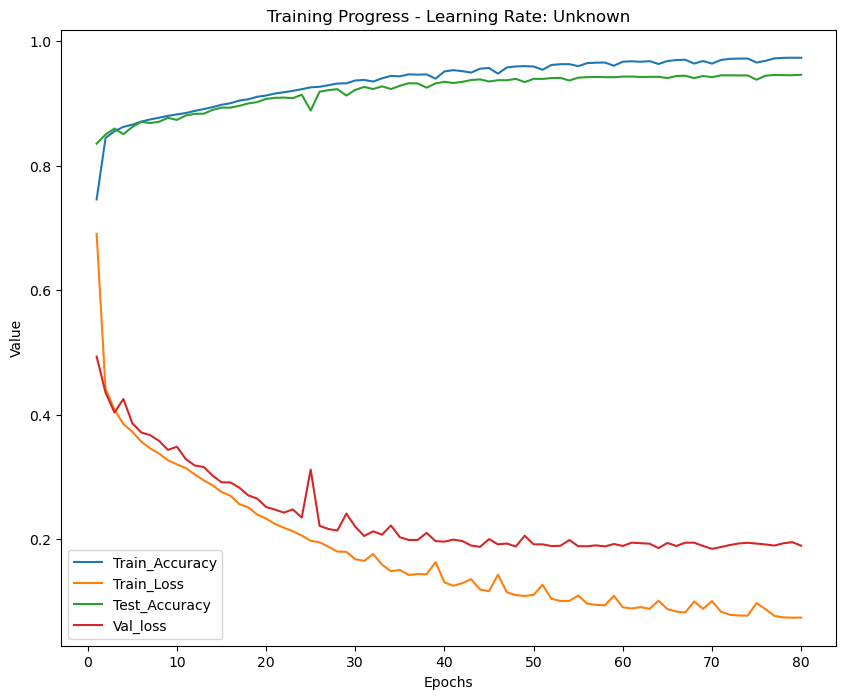

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Show history
history = pd.DataFrame(result.history)
print(history)

# Récupérer les valeurs des epochs et du learning rate
epochs = range(1, len(history) + 1)
learning_rate = history['lr'].values if 'lr' in history.columns else None

plt.figure(figsize=(10, 8))
plt.plot(epochs, history['categorical_accuracy'], label='Train_Accuracy')
plt.plot(epochs, history['loss'], label='Train_Loss')
plt.plot(epochs, history['val_categorical_accuracy'], label='Test_Accuracy')
plt.plot(epochs, history['val_loss'], label='Val_loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.title(f'Training Progress - Learning Rate: {learning_rate[-1] if learning_rate is not None else "Unknown"}')
plt.show()

# Affichage du learning rate séparément si disponible
if learning_rate is not None:
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, learning_rate, label='Learning Rate', color='purple')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.legend()
    plt.show()

# Évaluer les performances du modèle à l'aide des données de test 

Une fois le modèle entraîné, il est appliqué aux données de test.

Les données de test appliquées sont ensuite comparées aux véritables parcelles d'étiquettes d'occupation du sol des données de test.

L'évaluation est effectuée à l'aide du rapport de classification et de la matrice de confusion.

In [13]:
# Predict test data
prediction = np.argmax(model.predict(images_test), 3).flatten()
label = lcs_test.flatten()

170/170 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step


              precision    recall  f1-score   support

           1       0.95      0.96      0.95   8465201
           2       0.95      0.93      0.94  22504012
           3       0.96      0.94      0.95   7258777
           4       1.00      1.00      1.00  11841376
           5       0.93      0.93      0.93  15667235
           6       0.94      0.96      0.95  22063726

   micro avg       0.95      0.95      0.95  87800327
   macro avg       0.95      0.95      0.95  87800327
weighted avg       0.95      0.95      0.95  87800327



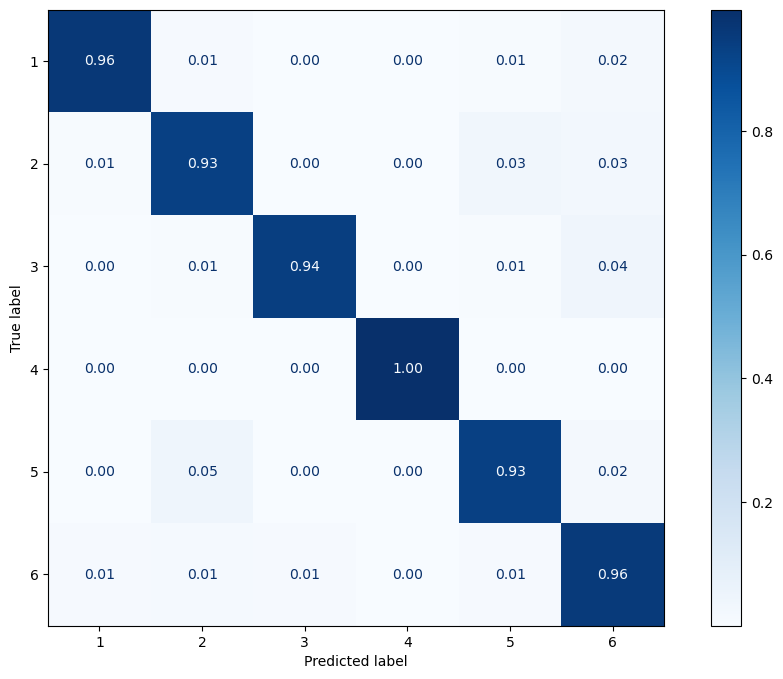

In [14]:
# Exclure la classe 0 des prédictions et des étiquettes en filtrant les classes uniques.
classes = np.unique(np.concatenate((label, prediction)))
classes = classes[classes != 0]  # Exclure la classe 0

# Calculer la matrice de confusion pour évaluer les performances du modèle sans la classe 0 :
# - Normaliser les valeurs de la matrice de confusion pour obtenir des pourcentages.
cm = confusion_matrix(label, prediction, labels=classes, normalize='true')

# Définir la taille du graphique pour la matrice de confusion (12x8 pouces).
fig, ax = plt.subplots(figsize=(12, 8)) 

# Afficher la matrice de confusion avec les étiquettes des classes et une palette de couleurs 'Blues'.
# - Formater les valeurs affichées avec 2 décimales.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax, cmap='Blues', values_format='.2f')

# Afficher un rapport de classification détaillant les performances (précision, rappel, F1-score).
print(classification_report(label, prediction, labels=classes))

# Enregistrer le graphique de la matrice de confusion dans un fichier PNG.
#output_path = 'plot/matrice_confusion.png'
#plt.savefig(output_path)

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━

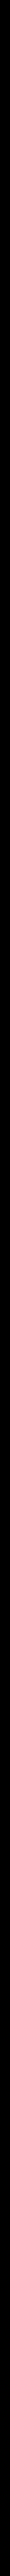

In [15]:
image_non_augment_size = int(len(images_test) / 8)

plt.figure(figsize=(8, image_non_augment_size * 2))

# Apply to classified image of the image
for x in range(0, image_non_augment_size - 1):
	index = x * 8

	image = images_test[index:(index + 1)]
	pred = model.predict(image)
	pred = np.argmax(pred, 3)[0]

	#plt.subplot(image_non_augment_size, 3, x * 3 + 1)
	#plt.imshow(image[0])

	plt.subplot(image_non_augment_size, 3, x * 3 + 2)
	plt.imshow(lcs_test[index], cmap=cmap, interpolation='nearest', vmin=1, vmax=6)
 
	plt.subplot(image_non_augment_size, 3, x * 3 + 3)
	plt.imshow(pred, cmap=cmap, interpolation='nearest', vmin=1, vmax=6)